In [1]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import math, time
import torchvision.models as models
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from tensorboardX import SummaryWriter

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

## 数据处理

## 通过本脚本可以在yahoo获得AAPL股市详情
'''
import datetime
import pandas as pd
import pandas_datareader.data as web
start = datetime.datetime(2012,1,1) # or start = '1/1/2016'
end = datetime.date.today()
prices = web.DataReader('AAPL', 'yahoo', start, end)
actions = web.DataReader('AAPL', 'yahoo-actions', start, end)
##把得到的数据变成csv文件
prices.to_csv('./stock\\AAPL.csv')
'''

In [2]:
#数据读入
s_data      = pd.read_csv('./stock\\AAPL.csv', parse_dates=True)
s_data_copy = s_data

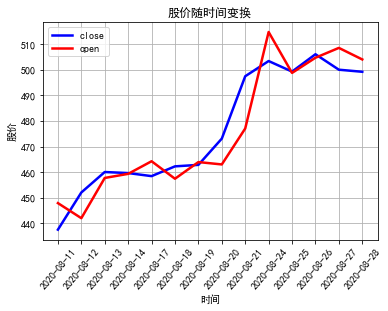

In [3]:
# 绘制最近的股价变化
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

t=2165
plt.plot(s_data["Date"][t:],s_data["Close"][t:],'b',lw=2.5)
plt.plot(s_data["Date"][t:],s_data["Open"][t:],'r',lw=2.5)
plt.legend(["close","open"])
plt.grid(True)
plt.axis('tight')
plt.xlabel('时间')
plt.ylabel('股价')
plt.title('股价随时间变换')
plt.setp(plt.gca().get_xticklabels(),rotation=50) #日期倾斜
plt.savefig('gs.png', dpi = 750)
plt.show()

In [4]:
Date_s = s_data["Date"]#提取时间参数
Date_s = np.array(Date_s)
Date_s = Date_s[20:]
s_data = s_data.drop(columns = ['Date'])#数据去除时间参数

In [5]:
#数据归一化
s_data  = s_data.fillna(method='ffill')
sel_col = ['High', 'Low', 'Open', 'Close', 'Volume','Adj Close']
scaler  = MinMaxScaler(feature_range=(0, 1))#放缩到0-1
for col in sel_col:
    s_data[col] = scaler.fit_transform(s_data[col].values.reshape(-1,1))
#转化成tensor
s_data  = np.array(s_data)
s_data  = torch.tensor(s_data)#形成tensor

In [6]:
sqe_len = 20 #前20天数据得到今天的闭市股价
stock_lenth = len(s_data) #数据长度
tr_val_slip = int( 0.8 * stock_lenth) #总数据的前80%作为训练集，后20%作为验证集
print("读取数据的天数",stock_lenth)
print("可以预测的天数",stock_lenth - sqe_len)

读取数据的天数 2179
可以预测的天数 2159


In [7]:
x = torch.zeros(stock_lenth - sqe_len, sqe_len, 6)
y = torch.zeros(stock_lenth - sqe_len,sqe_len, 1)

for i in range(0, stock_lenth - sqe_len -1):
    x[i] = s_data[i:i + sqe_len]#形成数据的输入
    y[i] = s_data[i+1 : i + sqe_len + 1][:,3].reshape(-1,1)#第三列表示闭市价格，同时是数据的目标值
#形成训练集和验证集合
train_x = x[0:tr_val_slip]
train_y = y[0:tr_val_slip]
vaild_x = x[tr_val_slip:]
vaild_y = y[tr_val_slip:]

#train_y_init_close = Date_close[0:tr_val_slip]
#vaild_y_init_close = Date_close[tr_val_slip + 20:]

print(train_x.shape,vaild_x.shape,train_y.shape,vaild_y.shape)

torch.Size([1743, 20, 6]) torch.Size([416, 20, 6]) torch.Size([1743, 20, 1]) torch.Size([416, 20, 1])


In [8]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,index):
        X = self.x[index]
        Y = self.y[index]
        return X, Y

In [9]:
batch_size = 1000
train_set = StockDataset(train_x,train_y)
vaild_set = StockDataset(vaild_x,vaild_y)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=False)
vaild_loader = DataLoader(vaild_set,batch_size=batch_size,shuffle=False)

In [10]:
print(train_loader.dataset.y.shape,vaild_loader.dataset.y.shape)

torch.Size([1743, 20, 1]) torch.Size([416, 20, 1])


## 模型

In [11]:
#6个特征的输入以及“close_price”的输出
input_dim  = 6
hidden_dim = 256
num_layers = 5
output_dim = 1

In [12]:
class Stock_LSTM_Regression(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(Stock_LSTM_Regression,self).__init__()
        #隐含层维度
        self.hidden_dim = hidden_dim
        #隐含层层数
        self.num_layers = num_layers
        
        # Building LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first = True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,x):
        # Initialize hidden and cell state with zero
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_().cuda()
        
        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out) 
        return out

In [13]:
modle_dome = Stock_LSTM_Regression(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()

k = torch.rand(8,20,6).cuda()#随机生成一组输入数据

with SummaryWriter(comment='lstm') as w:
    w.add_graph(modle_dome, (k, ))

print(modle_dome)

Stock_LSTM_Regression(
  (lstm): LSTM(6, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [14]:
Stock_LSTM    = Stock_LSTM_Regression(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()
loss_function = nn.MSELoss()
optimizer     = torch.optim.Adam(Stock_LSTM.parameters(), lr=2e-4)

In [15]:
#判断当天股价是否涨，1表示涨
def up_down(Price):
    l = len(Price)
    k = np.zeros((l-1))
    for i in range(l-1):
        if Price[i+1]>Price[i]:
            k[i] = 1
        else: k[i] = 0
    return k

def is_r(k):
    v = 0
    for i in range(len(k)):
        v = v + (k[i]==0)
    return v/len(k)

# 训练

In [16]:
num_epoch = 1000
tol_tiem = time.time()

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc  = 0.0
    val_loss   = 0
    val_acc    = 0.0
        
    Stock_LSTM.train()
    for i,(inpute_t, y_t) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = Stock_LSTM(inpute_t.cuda())
        loss   = loss_function(y_pred,y_t.cuda())        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    toc = up_down(y_pred.cpu().detach().numpy()[:,-1,0].reshape(-1,1)) - up_down(y_t.cpu().detach().numpy()[:,-1,0].reshape(-1,1))

        
    Stock_LSTM.eval()
    with torch.no_grad():
        for i,(inpute_v, y_v) in enumerate(vaild_loader):
            val_pred = Stock_LSTM(inpute_v.cuda())
            loss     = loss_function(val_pred,y_v.cuda())
            val_loss += loss.item()
    
    voc = up_down(val_pred.cpu().detach().numpy()[:,-1,0].reshape(-1,1)) - up_down(y_v.cpu().detach().numpy()[:,-1,0].reshape(-1,1))
               
    if epoch % 100 == 0 and epoch != 0:
        print('[%03d/%03d] Tra_Loss: %3.6f,Tra_acc: %3.6f||val_Loss: %3.6f, val_acc: %3.6f' % (epoch, num_epoch,train_loss,is_r(toc),val_loss,is_r(voc)))
        
print("训练以及验证的总运行总时间：",time.time() - tol_tiem)  

[100/1000] Tra_Loss: 0.008005,Tra_acc: 0.525606||val_Loss: 0.036739, val_acc: 0.571084
[200/1000] Tra_Loss: 0.003042,Tra_acc: 0.536388||val_Loss: 0.013416, val_acc: 0.539759
[300/1000] Tra_Loss: 0.001263,Tra_acc: 0.509434||val_Loss: 0.005917, val_acc: 0.491566
[400/1000] Tra_Loss: 0.000346,Tra_acc: 0.505391||val_Loss: 0.002094, val_acc: 0.455422
[500/1000] Tra_Loss: 0.000124,Tra_acc: 0.518868||val_Loss: 0.001428, val_acc: 0.460241
[600/1000] Tra_Loss: 0.000080,Tra_acc: 0.517520||val_Loss: 0.001315, val_acc: 0.462651
[700/1000] Tra_Loss: 0.000067,Tra_acc: 0.520216||val_Loss: 0.001199, val_acc: 0.472289
[800/1000] Tra_Loss: 0.000062,Tra_acc: 0.517520||val_Loss: 0.001115, val_acc: 0.465060
[900/1000] Tra_Loss: 0.000058,Tra_acc: 0.505391||val_Loss: 0.001016, val_acc: 0.455422
训练以及验证的总运行总时间： 153.49028182029724


In [17]:
y_vaild_pred = Stock_LSTM(vaild_loader.dataset.x.cuda()).cpu()
y_pred = y_pred.cpu()
y_vaild_pred.shape

torch.Size([416, 20, 1])

In [18]:
y = scaler.inverse_transform(vaild_loader.dataset.y.detach().numpy()[:,-1,0].reshape(-1,1))
y_vaild_pred = scaler.inverse_transform(y_vaild_pred.detach().numpy()[:,-1,0].reshape(-1,1))

In [19]:
y.shape,y_vaild_pred.shape

((416, 1), (416, 1))

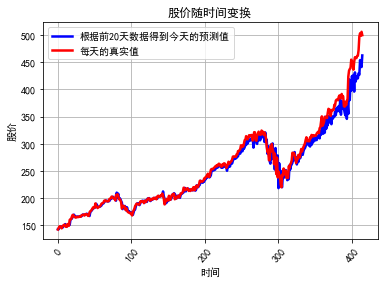

In [24]:
c = 0
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.plot(y_vaild_pred[c:len(y)-1],'b',lw=2.5)
plt.plot(y[c:len(y)-1],'r',lw=2.5)

#plt.scatter(Date_s[len(Date_s) - (len(y) - c - 1):len(Date_s)],y_vaild_pred[c:len(y)-1],'b',lw=2.5)
#plt.scatter(Date_s[len(Date_s) - (len(y) - c - 1):len(Date_s)],'r',lw=2.5)

plt.legend(["根据前20天数据得到今天的预测值","每天的真实值"])
plt.grid(True)
plt.axis('tight')
plt.xlabel('时间')
plt.ylabel('股价')
plt.title('股价随时间变换')
plt.setp(plt.gca().get_xticklabels(),rotation=50) #日期倾斜
plt.savefig('glp.png', dpi = 750)

plt.show()